- We will need to install libraries first

In [194]:
!pip install transformers qdrant_client datasets torch

In [195]:
from transformers import ViTImageProcessor, ViTModel
from qdrant_client import QdrantClient
from qdrant_client.http import models
from datasets import load_dataset, Dataset
import numpy as np
import torch

You can set up databases on you local computer as well but I am going with cloud since my local computer is limited about storage

In [196]:
#connect to the vector database
qdrant_url = ""
qdrant_api_key = ""

client = QdrantClient(
    url=qdrant_url,
    api_key=qdrant_api_key
     )

We are first going to create a collection.

In [197]:
my_collection = "image_collection"
client.recreate_collection(
    collection_name=my_collection,
    vectors_config=models.VectorParams(size=384, distance=models.Distance.COSINE)
)

True

- I am going to use Human Action Recognition dataset but you can apply any other dataset just remeber that the mode should be RGB
- We are going to add an index column for better seach experience
- I got test and train dataset indivudually to test it with unseen data

In [198]:
dataset_train = load_dataset(
    'Bingsu/Human_Action_Recognition', split='train'
)
values= list(range(len(dataset_train)))
dataset_train=dataset_train.add_column('image_id',values)


dataset_test = load_dataset(
    'Bingsu/Human_Action_Recognition', split='train'
)

values_test= list(range(len(dataset_test)))
dataset_test=dataset_test.add_column('image_id',values_test)

label of image is : 11


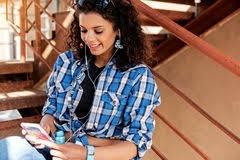

In [227]:
print(f"label of image is : {dataset_train[0]['labels']}")
dataset_train[0]['image']

- To exctrat embedding from the images, we are going to use pretrained facebook dino-vits16 Vision Transformer model.

In [200]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = ViTImageProcessor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16').to(device)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


- Now let's see an example of an embedding

In [201]:
image = dataset[123]["image"]
inputs = processor(images=image, return_tensors="pt").to(device)
inputs['pixel_values'].shape, inputs

(torch.Size([1, 3, 224, 224]),
 {'pixel_values': tensor([[[[2.2318, 2.2318, 2.1975,  ..., 2.1290, 2.1290, 2.1633],
           [2.2318, 2.2318, 2.1975,  ..., 2.1290, 2.1290, 2.1462],
           [2.2318, 2.2147, 2.1975,  ..., 2.1290, 2.1290, 2.1462],
           ...,
           [1.9407, 1.9407, 1.9235,  ..., 1.9749, 2.0263, 2.0948],
           [1.9578, 1.9578, 1.9407,  ..., 1.9749, 2.0263, 2.0948],
           [1.9578, 1.9578, 1.9407,  ..., 1.9749, 2.0263, 2.0948]],
 
          [[2.2535, 2.2535, 2.2185,  ..., 2.0959, 2.1310, 2.1660],
           [2.2535, 2.2535, 2.2185,  ..., 2.0959, 2.1310, 2.1485],
           [2.2535, 2.2360, 2.2185,  ..., 2.0959, 2.1310, 2.1485],
           ...,
           [2.1485, 2.1485, 2.1310,  ..., 2.1835, 2.2360, 2.3060],
           [2.1660, 2.1660, 2.1485,  ..., 2.1835, 2.2360, 2.3060],
           [2.1660, 2.1660, 2.1485,  ..., 2.1835, 2.2360, 2.3060]],
 
          [[2.3786, 2.3786, 2.3437,  ..., 2.3088, 2.3263, 2.3611],
           [2.3786, 2.3786, 2.3437,  ..., 2

- We are going to create payload for to insert along with image embeddings.
- This will help us to do search on vector databases with filtering.

In [ ]:
payload = dataset_train.select_columns([
    "labels", "image_id"
]).to_pandas().to_dict(orient="records")

payload[:3]

[{'labels': 11, 'image_id': 0},
 {'labels': 14, 'image_id': 1},
 {'labels': 7, 'image_id': 2}]

- Creating embeddings for inserting to DB usong or ViTs model
- This process will take some times(30 mins 12k image in my case)

In [204]:
def get_embeddings(batch):
    inputs = processor(images=batch['image'], return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs).last_hidden_state.mean(dim=1).cpu().numpy()
    batch['embeddings'] = outputs
    return batch

dataset_train = dataset_train.map(get_embeddings, batched=True, batch_size=16)
dataset_train

Map:   0%|          | 0/12600 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'labels', 'image_id', 'embeddings'],
    num_rows: 12600
})

- Now lets get the embeddings with creating id columns as well

In [205]:
ids = list(range(dataset_train.num_rows))
embeddings = np.array(dataset_train['embeddings'])

- Inserting to db

In [206]:
batch_size = 1000

for i in range(0, dataset_train.num_rows, batch_size):

    low_idx = min(i+batch_size, dataset_train.num_rows)

    batch_of_ids = ids[i: low_idx]
    batch_of_embs = embeddings[i: low_idx]
    batch_of_payloads = payload[i: low_idx]

    client.upsert(
        collection_name=my_collection,
        points=models.Batch(
            ids=batch_of_ids,
            vectors=batch_of_embs,
            payloads=batch_of_payloads
        )
    )

- We can check our collection info as follow:

In [229]:
collection_info = client.get_collection(collection_name='image_collection')
list(collection_info)

[('status', <CollectionStatus.GREEN: 'green'>),
 ('optimizer_status', <OptimizersStatusOneOf.OK: 'ok'>),
 ('vectors_count', 12600),
 ('indexed_vectors_count', 0),
 ('points_count', 12600),
 ('segments_count', 2),
 ('config',
  CollectionConfig(params=CollectionParams(vectors=VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None), shard_number=1, replication_factor=1, write_consistency_factor=1, on_disk_payload=True), hnsw_config=HnswConfig(m=16, ef_construct=100, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segment_number=0, max_segment_size=None, memmap_threshold=None, indexing_threshold=20000, flush_interval_sec=5, max_optimization_threads=1), wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0), quantization_config=None)),
 ('payload_schema', {})]

In [261]:
label_dict = {0: 'calling',
 1: 'clapping',
 2: 'cycling',
 3: 'dancing',
 4: 'drinking',
 5: 'eating',
 6: 'fighting',
 7: 'hugging',
 8: 'laughing',
 9: 'listening_to_music',
 10: 'running',
 11: 'sitting',
 12: 'sleeping',
 13: 'texting',
 14: 'using_laptop'}
def embed_image(image):
  #image = dataset[123]["image"]
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  processor = ViTImageProcessor.from_pretrained('facebook/dino-vits16')
  model = ViTModel.from_pretrained('facebook/dino-vits16').to(device)
  inputs = processor(images=image, return_tensors="pt").to(device)
  embedded_image = model(**inputs).last_hidden_state
  return embedded_image

def search_image(embedded_image):
  results = client.search(
    collection_name=my_collection,
    query_vector=one_embedding.mean(dim=1)[0].tolist(),
    limit=10)
  result_dict = {}
  for item in results:
    score = item.score
    label = item.payload['labels']
    mapped_label = label_dict.get(label, label)  # Use the mapped label or original label if not found
    result_dict[item.id] = {'score': score, 'label': mapped_label}
  df = pd.DataFrame(result_dict).T

  return df

image = dataset_test[47]['image']
label = dataset_test[47]['labels']
print(f'label of this image is {label}')
embedded_image = embed_image(image)
results = search_image(embedded_image)
results

label of this image is 12


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


,score,label
123,1.0,sleeping
10574,0.916811,listening_to_music
2699,0.909685,sleeping
7491,0.909277,listening_to_music
5417,0.907981,using_laptop
8423,0.907289,sleeping
7726,0.905439,sleeping
2882,0.904375,hugging
10916,0.904311,hugging
8354,0.903506,using_laptop
